![](../images/logo.png)

# Multi-Curve Bootstrapping

In [1]:
# import datetime as dt
# from dateutil.relativedelta import relativedelta
# import rivapy.marketdata.bootstrapping as bootstr
# import math
# import pandas as pd
# import pyvacon
# # the next line is a jupyter internal command to show the matplotlib graphs within the notebook
# %matplotlib inline
# import matplotlib.pyplot as plt

In [2]:
%load_ext autoreload
%autoreload 2

#imports
import datetime as dt
from dateutil.relativedelta import relativedelta
import pandas as pd
import matplotlib.pyplot as plt
from rivapy.marketdata.bootstrapping import bootstrap_curve, get_quote
from rivapy.instruments.deposit_specifications import DepositSpecification
from rivapy.instruments.fra_specifications import ForwardRateAgreementSpecification
from rivapy.instruments.ir_swap_specification import InterestRateSwapSpecification, IrFixedLegSpecification, IrFloatLegSpecification, IrOISLegSpecification, InterestRateBasisSwapSpecification
from rivapy.instruments.components import ConstNotionalStructure
from rivapy.tools.enums import DayCounterType, InterpolationType, ExtrapolationType

%matplotlib inline
import matplotlib.pyplot as plt
import math

from rivapy.tools._validators import print_member_values
from rivapy.pricing.deposit_pricing import DepositPricer
from rivapy.pricing.interest_rate_swap_pricing import InterestRateSwapPricer
from rivapy.marketdata.curves import DiscountCurve
from rivapy.tools.datetools import DayCounter, Period, Schedule, calc_end_day, calc_start_day
#testing
import rivapy.instruments.specification_from_csv as sfc 
from holidays import HolidayBase as _HolidayBase
from holidays import EuropeanCentralBank as _ECB

c:\Users\DrHansNguyen\Documents\MyRivacon\RiVaPy\rivapy\__init__.py:11: UserWarning: The pyvacon module is not available. You may not use all functionality without this module. Consider installing pyvacon.
  warnings.warn('The pyvacon module is not available. You may not use all functionality without this module. Consider installing pyvacon.')


## Introduction

In this notebook we introduce the basic principles of multi-curve bootstrapping. 

Before the credit crisis a single-curve framework was used for pricing interest rate derivatives. Both the forecasting of future cashflows as well as the discounting of future cashflows was based on the same curve. This curve was considered to be risk-free and was bootstrapped using a mixture of instruments indexed to rates with different tenors. 

Since the crisis, however, a widening of the spreads in tenor basis swaps has been observed. As a result, two interest rate swaps indexed e.g. to the 3M EURIBOR and 6M EURIBOR can no longer be priced using the same curve. Furthermore, a distinction needs to be made between the curve for the forward rates and the discount curve. This has led to the introduction of the multi-curve framework with separate curves for each tenor. 

In the multi-curve setup the curves are constructed based on instruments homogeneous in the referenced index. A set of instruments needs to be selected for each curve, with one instrument per maturity. Each instrument requires a quote as well as the respective instrument definition, which is called a specification in the context of pyvacon.

## Input Instruments for Interest Rate Curve Bootstrapping
The following instruments are currently available for ir curve bootstrapping

- Deposits
- IR Futures
- IR Swaps
- IR Basis-Swaps
- FX Swaps



### Setting up deposits / fixings

The fixing of the underlying reference rate is published daily and represents a certain average rate earned over a period corresponding to the tenor. The rate is calculated from quotes obtained from a panel of selected banks. The start date (spot date) of the period can deviate from the fixing date. This difference is referred to as the spot lag. 

The fixing is usually used as the starting point for the bootstrapping of forward curves. It can be specified as a deposit in pyvacon.

In [3]:
# calculation date
ref_date = dt.datetime(2019, 8, 31) 

# start date of the accrual period with spot lag equal to 2 days
start_date = ref_date + dt.timedelta(days=2)

# end date of the accrual period is 1 day after startdate
end_date = start_date + dt.timedelta(days=1)

# specification of the deposit
ccy = "EUR"
dcc = "Act365Fixed"#"Act360"normally a bond is ACT360, we keep consistency with the swaps
rate = 0.01
notional = 100.0
deposit = DepositSpecification(
    obj_id="OVERNIGHT_DEPOSIT",
    issuer="dummy_issuer",
    currency=ccy,
    issue_date=ref_date,
    maturity_date=end_date,
    notional=notional,
    rate=rate,
    day_count_convention=dcc,
)

# check dates, deposit start date cannot be the same as  maturity date
print(f"ref date: {ref_date}")
print(f"start date: {start_date} with spot lag 2 days")
print(f"end date: {end_date}")
print(f"adjusted start date: {deposit.start_date}")
print(f"adjusted end date: {deposit.maturity_date}")

    

ref date: 2019-08-31 00:00:00
start date: 2019-09-02 00:00:00 with spot lag 2 days
end date: 2019-09-03 00:00:00
adjusted start date: 2019-08-30 00:00:00
adjusted end date: 2019-09-03 00:00:00


### Setting up an interest rate swap
A plain vanilla interest rate swap is a financial contract in which a stream of fixed payments is exchanged for floating payments linked to a reference index. The par rate (r) of a swap is the fixed rate under which the value of the two streams (legs) is equal:
$$ 
r \cdot \sum_{i=1}^n dcf_{i} \cdot P(0,t_{i} ) = \sum_{k=1}^m F_{k} \cdot dcf_{k} \cdot P(0,t_{k}) 
$$ 

where $t_{i}$, $i=1,..,n$ and $t_{k}$, $i=1,..,m$ are the payment structures of the fixed and floating legs, and $P(0,t_{i/k})$ are the corresponding discount factors, $dcf_{i/k}$ is the day count fraction for the period $[t_{(i/k-1)},t_{i/k}]$, and $F_{k}$ is the expected value of  underlying reference rate for the period $[t_{(k-1)},t_{k}]$.

The standard payment frequency of the fixed leg depends on the currency of the swap as well as the tenor of the underlying. In the EUR market swaps are usually quoted with annual fixed payments.

The payment frequency of the floating leg usually coincides with the tenor of the underlying reference index. In some currencies, however, the floating rate can be compounded and payed out at less frequent intervals (e.g. CAD). 

In the context of pyvacon an IRS can be defined using an InterestRateSwapSpecification.

In [4]:
# start dates of the accrual periods corresponding to the tenor of the underlying index (3 months). The spot lag is set to 0.
start_dates = [ref_date + relativedelta(months=3*i) for i in range(4)]

# reset dates are equal to start dates if spot lag is 0.
reset_dates = start_dates

# the end dates of the accral periods
end_dates = [x + relativedelta(months=3) for x in start_dates]

# the actual payment dates of the cashflows may differ from the end of the accrual period (e.g. OIS). 
# in the standard case these two sets of dates coincide
pay_dates = end_dates
ns = ConstNotionalStructure(100.0)
spread = 0.00

# definition of the floating leg
float_leg =IrFloatLegSpecification(obj_id = 'dummy_float_leg', notional = ns, reset_dates=reset_dates, start_dates=start_dates, end_dates=end_dates,
                                   rate_start_dates=start_dates, rate_end_dates=end_dates, pay_dates=pay_dates, currency = "EUR", 
                                   udl_id="test_udl_id", fixing_id="test_fixing_id", day_count_convention="Act365Fixed", spread=spread)

# # definition of the fixed leg
#Note that a fixed rate is given for the specification as it is required. 
#However, for the creation of the bootrstrapped curve, the market quotes are used as the target swap par rate
fixed_leg = IrFixedLegSpecification(fixed_rate = 0.01, obj_id = 'dummy_fixed_leg', notional = 100.0, start_dates=start_dates, 
                                    end_dates=end_dates, pay_dates=pay_dates, currency='EUR', day_count_convention='Act365Fixed')

# # definition of the IR swap
ir_swap = InterestRateSwapSpecification(obj_id="3M_SWAP", notional=ns, issue_date=ref_date, maturity_date=pay_dates[-1],
                                        pay_leg=fixed_leg, receive_leg=float_leg,currency='EUR', day_count_convention="Act365Fixed",
                                        issuer="dummy_issuer", securitization_level="COLLATERALIZED")
 

In [5]:
#2Y maturity 3M swap
start_dates2 = [ref_date + relativedelta(months=3*i) for i in range(4*2)]
reset_dates2 = start_dates2
end_dates2 = [x + relativedelta(months=3) for x in start_dates2]
pay_dates2 = end_dates2

ns = ConstNotionalStructure(100.0)
spread = 0.00

# # definition of the floating leg
float_leg2 =IrFloatLegSpecification(obj_id = 'dummy_float_leg2', notional = ns, reset_dates=reset_dates2, start_dates=start_dates2, end_dates=end_dates2,
                                   rate_start_dates=start_dates2, rate_end_dates=end_dates2, pay_dates=pay_dates2, currency = "EUR", 
                                   udl_id="test_udl_id", fixing_id="test_fixing_id", day_count_convention="Act365Fixed", spread=spread)

# # definition of the fixed leg
fixed_leg2 = IrFixedLegSpecification(fixed_rate = 0.01, obj_id = 'dummy_fixed_leg2', notional = 100.0, start_dates=start_dates2, 
                                    end_dates=end_dates2, pay_dates=pay_dates2, currency='EUR', day_count_convention='Act365Fixed')

# # definition of the IR swap
ir_swap2 = InterestRateSwapSpecification(obj_id="3M_SWAP2", notional=ns, issue_date=ref_date, maturity_date=pay_dates2[-1],
                                        pay_leg=fixed_leg2, receive_leg=float_leg2,currency='EUR', day_count_convention="Act365Fixed",
                                        issuer="dummy_issuer", securitization_level="COLLATERALIZED")

### Setting up an overnight indexed swap
An OIS is an interest rate swap where the floating payments are linked to a compounded overnight rate. The floating payments are obtained as:

 $$ N\prod_{i=1}^n (1+dcf_{i}\cdot I_{i-1})-1$$
where $N$ is the notional, $dcf_{i}$ is the day count fraction for the one-day period $[t_{i-1},t_{i}]$ and $I_{i-1}$ is the fixing of the ON rate corresponding to time $t_{i-1}$.

The overnight rate represents the default risk over one night and can, therefore, be regarded as mostly risk free. This rate is used to discount cashflows from collateralized trades as this rate is most often paid as interest for the collateral.

In the current pyvacon setting the OIS will be defined as plain vanilla IRS without compounding.

### Setting up a tenor basis swap

Basis swaps can be quoted in a fixed-fixed (as a portfolio of 2 fixed vs floating IRS) or in a float-float (as a single swap) convention. The market standard usually depends on the currency. 

#### Fixed-Fixed Basis Swaps (EUR convention)

In certain currencies (e.g EUR, SEK, DKK and NOK) basis swaps are quoted as the difference between two IRS with identical fixed legs and floating legs indexed to different tenors. With this convention the spread is usually paid annually, independent of the tenors of the floating legs. The par spread $s^{xy}$ is defined via:

$$ s^{xy} \cdot \sum_{l} dcf_{i} \cdot P(0,t_{l})= \sum_{k} dcf_{k} \cdot F_{k}^{y} \cdot P(0,t_{k})-\sum_{i} dcf_{i} \cdot F_{i}^{x} \cdot P(0,t_{i} )$$

where $t_{i}$, $t_{k}$   are grids corresponding to the tenors $x,y$ with $x<y$ , $t_{l}$ is the fixed payment grid.

#### Float-Float Basis Swaps

In case of a single swap notation, the frequency of the floating payments usually coincides with the tenors of the reference rate. The spread is paid with the shorter leg. The par spread $s^{xy}$ is defined via:

$$\sum_{i} dcf_{i} \cdot (F_{i}^{x}+s^{xy} ) \cdot P(0,t_{i})= \sum_{k}dcf_{k} \cdot F_{k}^{y} \cdot P(0,t_{k})$$
where $t_{i}$, $t_{k}$ are grids corresponding to the tenors $x,y$ with $x<y$ .

For some currencies (USD, CAD) the floating leg corresponding to the shorter tenor is compounded to align the payment of both legs. In this case the payment frequency of the spread coincides with the longer tenor.

In pyvacon a basis swap can be specified using InterestRateBasisSwapSpecification. Here two floating legs corresponding to the two reference indices need to be defined along with a fixed leg corresponding to the spread payments.


In [6]:
# # we consider a 3M vs 6M basis swap. A pay and receive floating legs need to be specified (spread = receive - pay).
# # The definition of the pay leg (3M) will be taken from the ir swap above 
# floatleg_3M = floatleg

# # get the 6M floating leg (receive leg)
# start_dates_6M = [refdate + relativedelta(months=6 * i) for i in range(2)]
# reset_dates_6M = start_dates_6M
# end_dates_6M = [refdate + relativedelta(months=6 * (i+1)) for i in range(2)]
# notionals_6M = [1.0 for i in range(len(start_dates_6M))]
# floatleg_6M = pyvacon.finance.specification.IrFloatLegSpecification(
#     notionals_6M, reset_dates_6M, start_dates_6M, end_dates_6M, end_dates_6M,
#     'EUR', 'dummy_udl', 'Act365Fixed', 0.0)

# # the 3M leg is the payleg, 6M - the receve leg.
# basis_swap = pyvacon.finance.specification.InterestRateBasisSwapSpecification(
#     '3M6M_BASIS_SWAP', 'test', 'COLLATERALIZED', 'EUR', end_dates_6M[-1], floatleg_3M, floatleg_6M,  fixedleg)

In [7]:
# we consider a 3M vs 6M basis swap. A pay and receive floating legs need to be specified (spread = receive - pay).
 
# these inputs must be given by user
holidays = _ECB()

# --- Defining general fields ---
instr = "TBS"
currency = "EUR"
maturity = "1M"
spot_lag = "2D"
roll_conv = "ModifiedFollowing"
fixDayCount = "Act360"
floatDayCount = "Act360"
basisDayCount = "Act360"
rollConvFix = "ModifiedFollowing"
rollConvBasis = "ModifiedFollowing"
# --- Long (receive) leg info ---
long_index = "EURIBOR"
long_tenor = "6M"
long_freq = "6M"

# --- Short (pay) leg info ---
short_index = "EURIBOR"
short_tenor = "3M"
short_freq = "3M"

# --- Spread (basis quote) ---
spread_rate = 9.85 / 10000.0  # e.g. 8.5 bps -> 0.00085

# --- Spot and maturity dates ---
spot_date = calc_end_day(ref_date, spot_lag, roll_conv, holidays)
expiry = calc_end_day(spot_date, maturity, roll_conv, holidays)
label = f"{instr}_{maturity}"

ns = ConstNotionalStructure(1.0)

# --------------------------------------------
# PAY FLOATING LEG (short tenor, pays basis)
short_schedule = Schedule(
    start_day=spot_date,
    end_day=expiry,
    time_period=short_freq,
    business_day_convention=roll_conv,
    calendar=holidays,
    ref_date=ref_date,
).generate_dates(False)

short_start = short_schedule[:-1]
short_end = short_schedule[1:]
short_pay = short_end
short_reset = Schedule(
    start_day=spot_date,
    end_day=expiry,
    time_period=short_tenor,
    business_day_convention=roll_conv,
    calendar=holidays,
    ref_date=ref_date,
).generate_dates(False)[:-1]

pay_leg = IrFloatLegSpecification(
    obj_id=label + "_pay_leg",
    notional=ns,
    reset_dates=short_reset,
    start_dates=short_start,
    end_dates=short_end,
    rate_start_dates=short_start,
    rate_end_dates=short_end,
    pay_dates=short_pay,
    currency=currency,
    udl_id=short_index,
    fixing_id="test_fixing_id",
    day_count_convention=floatDayCount,
    spread=0.0,  # this is the quoted basis
)

# --------------------------------------------
# RECEIVE FLOATING LEG (long tenor)

long_schedule = Schedule(
    start_day=spot_date,
    end_day=expiry,
    time_period=long_freq,
    business_day_convention=roll_conv,
    calendar=holidays,
    ref_date=ref_date,
).generate_dates(False)

long_start = long_schedule[:-1]
long_end = long_schedule[1:]
long_pay = long_end
long_reset = Schedule(
    start_day=spot_date,
    end_day=expiry,
    time_period=long_tenor,
    business_day_convention=roll_conv,
    calendar=holidays,
    ref_date=ref_date,
).generate_dates(False)[:-1]

receive_leg = IrFloatLegSpecification(
    obj_id=label + "_receive_leg",
    notional=ns,
    reset_dates=long_reset,
    start_dates=long_start,
    end_dates=long_end,
    rate_start_dates=long_start,
    rate_end_dates=long_end,
    pay_dates=long_pay,
    currency=currency,
    udl_id=long_index,
    fixing_id="test_fixing_id",
    day_count_convention=floatDayCount,
    spread=0.0,
)

# --------------------------------------------
#  FIXED SPREAD LEG
# The spread leg represents the fixed +x bps cashflows applied to the pay leg
spread_schedule = Schedule(
    start_day=spot_date,
    end_day=expiry,
    time_period=short_freq,  # same freq as short leg
    business_day_convention=rollConvFix,
    calendar=holidays,
    ref_date=ref_date,
).generate_dates(False)

spread_start = spread_schedule[:-1]
spread_end = spread_schedule[1:]
spread_pay = spread_end

spread_leg = IrFixedLegSpecification(
    fixed_rate=spread_rate,
    obj_id=label + "_spread_leg",
    notional=1.0,
    start_dates=spread_start,
    end_dates=spread_end,
    pay_dates=spread_pay,
    currency=currency,
    day_count_convention=fixDayCount,
)

# --------------------------------------------
# Combine into full TBS object
basis_swap = InterestRateBasisSwapSpecification(
    obj_id=label,
    notional=ns,
    issue_date=ref_date,
    maturity_date=expiry,
    pay_leg=pay_leg,
    receive_leg=receive_leg,
    spread_leg=spread_leg,
    currency=currency,
    day_count_convention=floatDayCount,
    issuer="dummy_issuer",
    securitization_level="COLLATERALIZED",
)



## Bootstrapping EUR Curves
In the EUR market most interest rate derivatives are indexed to the Euribor benchmark rate and the Euro OverNight Index Average (Eonia) in case of Overnight indexed swaps (https://www.emmi-benchmarks.eu/emmi/about-us.html). Derivatives indexed to the 1M, 3M, 6M and 12M tenors can be found. 

In this notebook we present the construction of the OIS discounting curve and the two most commonly used tenor curves - the 3M and 6M tenors.


The bootstrapping of different tenors needs to be performed sequentially. At first the OIS curve needs to be constructed, since it is used as the discount curve in the bootstrapping algorithm for all other tenors. The OIS curve is calibrated under the assumption that the forward and discount curves coincide. 

The order of construction of the other tenors depends on the defined input instruments. If the derivatives only depend on one tenor (outright quotes), there are no restrictions on the order. However, for most currencies, one or two tenors will be more liquid (depending on the maturity) and all other tenors will be represented as basis swaps with respect to the main tenor. In this case the correct bootstrapping order needs to be followed and the corresponding basis index needs to be provided.

### Sample curve specification

We define a few example specifications to show the expected syntax. Further below we showcase real data.

In [8]:
# sample "OIS" discounting curve
instruments = [deposit, ir_swap]
quotes = [0.0025, 0.005]
sample_dc = bootstrap_curve(
            ref_date=ref_date,
            curve_id="OIS_DC",
            day_count_convention="Act360",  # taken the first entry and assume is valid for all other deposits
            instruments=instruments,
            quotes=quotes,
            interpolation_type=InterpolationType.LINEAR_LOG,
            extrapolation_type=ExtrapolationType.LINEAR_LOG,
        )


In [9]:
# sample 3M EURIBOR curve with OIS discounting 
instruments = [ir_swap, ir_swap2]
quotes = [0.003, 0.0075]

euribor_3m = bootstrap_curve(
            ref_date=ref_date,
            curve_id="EUR3M_DC",
            day_count_convention="Act360",  # taken the first entry and assume is valid for all other deposits
            instruments=instruments,
            quotes=quotes,
            curves={"discount_curve": sample_dc},
            interpolation_type=InterpolationType.LINEAR_LOG,
            extrapolation_type=ExtrapolationType.LINEAR_LOG,
        )

In [10]:
# sample 6M EURIBOR curve with ois bootstrapping and the 3M EURIBOR curve as the basis index
quotes = [0.003, 0.006]
# the basis swap is used instead of the ir swap
instruments[1] = basis_swap
#euribor_6m = bootstr.bootstrap_curve(refdate, 'EUR6M_DC', 'Act365Fixed', instruments, quotes, estr, euribor_3m)


euribor_6m = bootstrap_curve(
            ref_date=ref_date,
            curve_id="EUR6M_DC",
            day_count_convention="Act360",  # taken the first entry and assume is valid for all other deposits
            instruments=instruments,
            quotes=quotes,
            curves={"discount_curve": sample_dc, "basis_curve": euribor_3m},
            interpolation_type=InterpolationType.LINEAR_LOG,
            extrapolation_type=ExtrapolationType.LINEAR_LOG,
        )


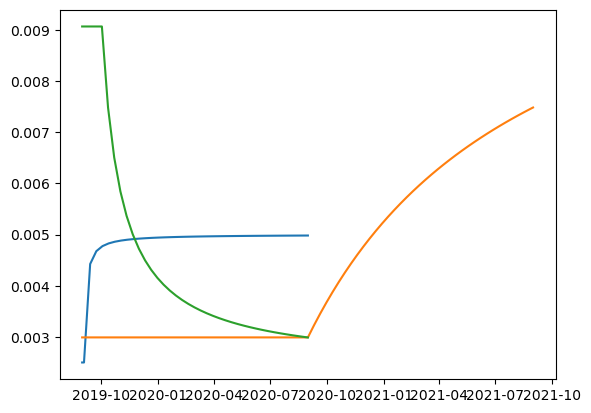

In [11]:
sample_dc.plot()
euribor_3m.plot()
euribor_6m.plot()

### EUR market data

We now present the calibration of EUR curves based on actual market data. The input quotes as well as the instrument definition and conventions are provided in an input csv. file and are loaded into a pandas data frame object:

In [12]:
# set holiday calendar 
holidays= _ECB()

# set directory and file name for Input Quotes
dirName = "./sample_data" 
fileName = "/multi_dates_tbs.csv"

# get instrument quotes and conventions from input .csv file 
dfQuotes = pd.read_csv(dirName + fileName, sep=";", decimal=",")
column_names = list(dfQuotes.columns)

dfQuotes

Date Maturity Instrument Currency     Quote UnderlyingIndex  \
0      26.09.2025       7Y        OIS      USD   0.03449            SOFR   
1      26.09.2025      14D        OIS      EUR   0.02013           EONIA   
2      26.09.2025       1M        OIS      EUR   0.02013           EONIA   
3      26.09.2025       2M        OIS      EUR   0.02012           EONIA   
4      26.09.2025       3M        OIS      EUR   0.02016           EONIA   
...           ...      ...        ...      ...       ...             ...   
11323  23.07.2025       3y        TBS      EUR   8.90000         EURIBOR   
11324  23.07.2025       6y        TBS      EUR   6.95000         EURIBOR   
11325  23.07.2025      60y        TBS      EUR  -2.35000         EURIBOR   
11326  23.07.2025      30y        TBS      EUR  20.40000         EURIBOR   
11327  23.07.2025       8y        TBS      EUR  11.00000         EURIBOR   

      UnderlyingTenor UnderlyingPaymentFrequency  BasisIndex  BasisTenor  ...  \
0                  1D                         1Y         NaN         NaN  ...   
1                  1D                        14D         NaN         NaN  ...   
2                  1D                         1M         NaN         NaN  ...   
3                  1D                         2M         NaN         NaN  ...   
4                  1D                         3M         NaN         NaN  ...   
...               ...                        ...         ...         ...  ...   
11323             12M                         1y         NaN         NaN  ...   
11324              6M                         6M         NaN         NaN  ...   
11325              6M                         6M         NaN         NaN  ...   
11326             12M                         1y         NaN         NaN  ...   
11327             12M                         1y         NaN         NaN  ...   

       DayCountFixed DayCountFloat DayCountBasis RollConventionFixed  \
0             Act360        Act360           NaN   ModifiedFollowing   
1             Act360        Act360           NaN   ModifiedFollowing   
2             Act360        Act360           NaN   ModifiedFollowing   
3             Act360        Act360           NaN   ModifiedFollowing   
4             Act360        Act360           NaN   ModifiedFollowing   
...              ...           ...           ...                 ...   
11323         Act360        Act360           NaN   ModifiedFollowing   
11324         Act360        Act360           NaN   ModifiedFollowing   
11325         Act360        Act360           NaN   ModifiedFollowing   
11326         Act360        Act360           NaN   ModifiedFollowing   
11327         Act360        Act360           NaN   ModifiedFollowing   

       RollConventionFloat RollConventionBasis SpotLag  UnderlyingTenorShort  \
0        ModifiedFollowing                 NaN      2D                   NaN   
1        ModifiedFollowing                 NaN      2D                   NaN   
2        ModifiedFollowing                 NaN      2D                   NaN   
3        ModifiedFollowing                 NaN      2D                   NaN   
4        ModifiedFollowing                 NaN      2D                   NaN   
...                    ...                 ...     ...                   ...   
11323    ModifiedFollowing                 NaN      2D                    6M   
11324    ModifiedFollowing                 NaN      2D                    3M   
11325    ModifiedFollowing                 NaN      2D                    3M   
11326    ModifiedFollowing                 NaN      2D                    6M   
11327    ModifiedFollowing                 NaN      2D                    6M   

      UnderlyingPaymentFrequencyShort PaymentFrequencyFixedShort  
0                                 NaN                        NaN  
1                                 NaN                        NaN  
2                                 NaN                        NaN  
3                                

### €STR curve

In [13]:
# Select for a specific date
mon = "09"
day = "24"
year = "2025"
date_str = f"{day}.{mon}.{year}"
ref_date = dt.datetime(int(year), int(mon), int(day))

# get input data for the ESTR curve
dfQuotesOIS = dfQuotes[(dfQuotes["Date"] == date_str) 
                       & (dfQuotes["Currency"] == "EUR") 
                       & (dfQuotes["UnderlyingIndex"] == "EONIA") 
                       & (dfQuotes["Instrument"] == "OIS")]

ins_spec = sfc.load_specifications_from_pd(dfQuotesOIS, ref_date, holidays)
ins_quotes = dfQuotesOIS["Quote"].tolist()


# get estr curve             

estrCurve = bootstrap_curve(
            ref_date=ref_date,
            curve_id="eonia",
            day_count_convention=dfQuotes["DayCountFixed"].tolist()[0],  # taken the first entry and assume is valid for all other deposits
            instruments=ins_spec,
            quotes=ins_quotes,
        )

### 3M EURIBOR curve

In [14]:
# get input data for the 3M EURIBOR curve
dfQuotes3M = dfQuotesOIS = dfQuotes[(dfQuotes["Date"] == date_str) 
                       & (dfQuotes["Currency"] == "EUR") 
                       & (dfQuotes["UnderlyingIndex"] == "EURIBOR") 
                       & (dfQuotes["Instrument"] == "IRS")
                       & (dfQuotes["UnderlyingTenor"] == "3M")]


ins_spec_3m = sfc.load_specifications_from_pd(dfQuotes3M, ref_date, holidays)
ins_quotes_3m = dfQuotes3M["Quote"].tolist()

# set up curve parameters for the 3M EURIBOR curve. The eonia curve is used for bootstrapping
curves = {"discount_curve": estrCurve}

# get 3M euribor curve
euribor3MCurve = bootstrap_curve(
    ref_date=ref_date,
    curve_id="euribor_3m",
    day_count_convention=dfQuotes3M["DayCountFixed"].tolist()[0],  # taken the first entry and assume is valid for all other deposits
    instruments=ins_spec_3m,
    quotes=ins_quotes_3m,
    curves=curves,
    interpolation_type=InterpolationType.LINEAR_LOG,
    extrapolation_type=ExtrapolationType.LINEAR_LOG,
)

### 6M EURIBOR curve

In [15]:
# get input data for the 6M EURIBOR curve
dfQuotes6M = dfQuotes[
    (dfQuotes["Date"] == date_str)
    & (dfQuotes["Currency"] == "EUR")
    & (dfQuotes["UnderlyingIndex"] == "EURIBOR")
    & (dfQuotes["Instrument"] == "TBS")
    & (dfQuotes["UnderlyingTenor"] == "6M")
]
ins_spec_tbs = sfc.load_specifications_from_pd(dfQuotes6M, ref_date, holidays)
ins_quotes_tbs = (dfQuotes6M["Quote"] / 10000.0).tolist()

# set up curve parameters for the 6M EURIBOR curve by adding 3m euribor curve as basis curve
curves["basis_curve"] = euribor3MCurve

# get 6M euribor curve             
euribor6MCurve = bootstrap_curve(
            ref_date=ref_date,
            curve_id="euribor_6m",
            day_count_convention=dfQuotes6M["DayCountFixed"].tolist()[0],  # taken the first entry and assume is valid for all other deposits
            instruments=ins_spec_tbs,
            quotes=ins_quotes_tbs,
            curves=curves,
            interpolation_type=InterpolationType.LINEAR_LOG,
            extrapolation_type=ExtrapolationType.LINEAR_LOG,
            # interpolation_type=InterpolationType.HAGAN_DF,
            # extrapolation_type=ExtrapolationType.CONSTANT_DF,
        )

## Plotting IR Curves



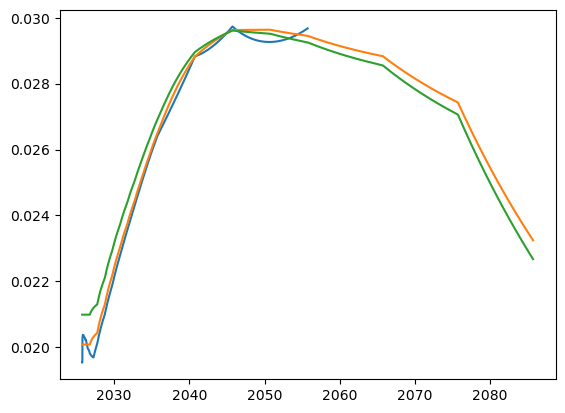

In [16]:
estrCurve.plot()
euribor3MCurve.plot()
euribor6MCurve.plot()